In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm # for uncertainty quantification and model calibration
from scipy.integrate import solve_ivp # to solve ODE system
from scipy import optimize # to solve minimization problem from least-squares fitting
from numba import jit # to accelerate ODE system RHS evaluations
import theano # to control better pymc3 backend and write a wrapper
import theano.tensor as t # for the wrapper to a custom model to pymc3

# Plotting libs
import matplotlib.pyplot as plt


seed = 12345 # for the sake of reproducibility :)
np.random.seed(seed)

plt.style.use('seaborn-talk') # beautify the plots!

THEANO_FLAGS='optimizer=fast_compile' # A theano trick

In [120]:
df = pd.read_excel (r'/Users/apolloni/Documents/Projects/Covid/Covid Data.xlsx')
df_covid=df.copy()
df_covid=df_covid[["Day","Cases","Death","Cumulative_Recovered"]]
df_covid.columns=['Date','Confirmed','Deaths',"Recovered"]

df_covid['Country/Region'] = "Senegal"


columns_to_filter_cases = ["Country/Region", "Date", "Confirmed", "Deaths","Recovered"]
df_covid_cases = df_covid[columns_to_filter_cases]

df_covid_cases.head()

Country/Region       Date  Confirmed  Deaths  Recovered
0        Senegal 2020-03-02          1       0          0
1        Senegal 2020-03-03          2       0          0
2        Senegal 2020-03-04          4       0          0
3        Senegal 2020-03-05          4       0          0
4        Senegal 2020-03-06          3       0          1

In [121]:
print( {df_covid['Date'].min()})
print({df_covid['Date'].max()})
print({df_covid['Date'].max() - df_covid['Date'].min()})

set([Timestamp('2020-03-02 00:00:00')])
set([Timestamp('2020-06-24 00:00:00')])
set([Timedelta('114 days 00:00:00')])


In [122]:
df_covid.rename(
    columns={
        'Date': 'date', 
        'Province/State':'state',
        'Country/Region':'country',
        'Last Update':'last_updated',
        'Confirmed': 'confirmed',
        'Deaths':'deaths',
        'Recovered':'recovered'}, 
    inplace=True
)

df_covid

date  confirmed  deaths  recovered  country
0   2020-03-02          1       0          0  Senegal
1   2020-03-03          2       0          0  Senegal
2   2020-03-04          4       0          0  Senegal
3   2020-03-05          4       0          0  Senegal
4   2020-03-06          3       0          1  Senegal
5   2020-03-07          3       0          1  Senegal
6   2020-03-08          3       0          1  Senegal
7   2020-03-09          3       0          1  Senegal
8   2020-03-10          3       0          1  Senegal
9   2020-03-11          3       0          2  Senegal
10  2020-03-12          8       0          2  Senegal
11  2020-03-13         19       0          2  Senegal
12  2020-03-14         22       0          2  Senegal
13  2020-03-15         24       0          2  Senegal
14  2020-03-16         25       0          2  Senegal
15  2020-03-17         29       0          2  Senegal
16  2020-03-18         34       0          2  Senegal
17  2020-03-19         33       0          5  Senegal
18  2020-03-20         42       0          5  Senegal
19  2020-03-21         51       0          5  Senegal
20  2020-03-22         62       0          5  Senegal
21  2020-03-23         71       0          8  Senegal
22  2020-03-24         78       0          8  Senegal
23  2020-03-25         90       0          9  Senegal
24  2020-03-26         96       0          9  Senegal
25  2020-03-27        108       0         11  Senegal
26  2020-03-28        112       0         18  Senegal
27  2020-03-29        115       0         27  Senegal
28  2020-03-30        134       0         28  Senegal
29  2020-03-31        135       0         40  Senegal
..         ...        ...     ...        ...      ...
85  2020-05-26       1559       1       1565  Senegal
86  2020-05-27       1628       2       1586  Senegal
87  2020-05-28       1622       1       1686  Senegal
88  2020-05-29       1649       2       1738  Senegal
89  2020-05-30       1731       1       1761  Senegal
90  2020-05-31       1801       0       1801  Senegal
91  2020-06-01       1838       0       1858  Senegal
92  2020-06-02       1838       1       1954  Senegal
93  2020-06-03       1823       2       2063  Senegal
94  2020-06-04       1813       0       2162  Senegal
95  2020-06-05       1833       0       2276  Senegal
96  2020-06-06       1689       2       2512  Senegal
97  2020-06-07       1690       2       2588  Senegal
98  2020-06-08       1678       0       2699  Senegal
99  2020-06-09       1654       3       2809  Senegal
100 2020-06-10       1702       0       2885  Senegal
101 2020-06-11       1709       3       2994  Senegal
102 2020-06-12       1694       1       3100  Senegal
103 2020-06-13       1707       4       3228  Senegal
104 2020-06-14       1685       0       3344  Senegal
105 2020-06-15       1684       4       3424  Senegal
106 2020-06-16       1651       6       3525  Senegal
107 2020-06-17       1689       3       3606  Senegal
108 2020-06-18       1682       3       3716  Senegal
109 2020-06-19       1771       3       3788  Senegal
110 2020-06-20       1841       3       3859  Senegal
111 2020-06-21       1884       2       3919  Senegal
112 2020-06-22       1930       2       3953  Senegal
113 2020-06-23       1898       3       4046  Senegal
114 2020-06-24       1963       4       4072  Senegal

[115 rows x 5 columns]

In [126]:
def get_df_country_cases(df, country_name):
    df_grouped_country = df[df['country'] == country_name].reset_index()
    df_grouped_country_date = df_grouped_country.groupby('date')['date', 'confirmed','recovered', 'deaths'].sum().reset_index()
    df_grouped_country_date["confirmed_marker"] = df_grouped_country_date.shape[0] * ['Confirmed']
    df_grouped_country_date["deaths_marker"] = df_grouped_country_date.shape[0] * ['Deaths']
    return df_grouped_country_date

In [127]:
df_grouped_Senegal = get_df_country_cases(df_covid, "Senegal")

df_grouped_Senegal

date  confirmed  recovered  deaths confirmed_marker deaths_marker
0   2020-03-02          1          0       0        Confirmed        Deaths
1   2020-03-03          2          0       0        Confirmed        Deaths
2   2020-03-04          4          0       0        Confirmed        Deaths
3   2020-03-05          4          0       0        Confirmed        Deaths
4   2020-03-06          3          1       0        Confirmed        Deaths
5   2020-03-07          3          1       0        Confirmed        Deaths
6   2020-03-08          3          1       0        Confirmed        Deaths
7   2020-03-09          3          1       0        Confirmed        Deaths
8   2020-03-10          3          1       0        Confirmed        Deaths
9   2020-03-11          3          2       0        Confirmed        Deaths
10  2020-03-12          8          2       0        Confirmed        Deaths
11  2020-03-13         19          2       0        Confirmed        Deaths
12  2020-03-14         22          2       0        Confirmed        Deaths
13  2020-03-15         24          2       0        Confirmed        Deaths
14  2020-03-16         25          2       0        Confirmed        Deaths
15  2020-03-17         29          2       0        Confirmed        Deaths
16  2020-03-18         34          2       0        Confirmed        Deaths
17  2020-03-19         33          5       0        Confirmed        Deaths
18  2020-03-20         42          5       0        Confirmed        Deaths
19  2020-03-21         51          5       0        Confirmed        Deaths
20  2020-03-22         62          5       0        Confirmed        Deaths
21  2020-03-23         71          8       0        Confirmed        Deaths
22  2020-03-24         78          8       0        Confirmed        Deaths
23  2020-03-25         90          9       0        Confirmed        Deaths
24  2020-03-26         96          9       0        Confirmed        Deaths
25  2020-03-27        108         11       0        Confirmed        Deaths
26  2020-03-28        112         18       0        Confirmed        Deaths
27  2020-03-29        115         27       0        Confirmed        Deaths
28  2020-03-30        134         28       0        Confirmed        Deaths
29  2020-03-31        135         40       0        Confirmed        Deaths
..         ...        ...        ...     ...              ...           ...
85  2020-05-26       1559       1565       1        Confirmed        Deaths
86  2020-05-27       1628       1586       2        Confirmed        Deaths
87  2020-05-28       1622       1686       1        Confirmed        Deaths
88  2020-05-29       1649       1738       2        Confirmed        Deaths
89  2020-05-30       1731       1761       1        Confirmed        Deaths
90  2020-05-31       1801       1801       0        Confirmed        Deaths
91  2020-06-01       1838       1858       0        Confirmed        Deaths
92  2020-06-02       1838       1954       1        Confirmed        Deaths
93  2020-06-03       1823       2063       2        Confirmed        Deaths
94  2020-06-04       1813       2162       0        Confirmed        Deaths
95  2020-06-05       1833       2276       0        Confirmed        Deaths
96  2020-06-06       1689       2512       2        Confirmed        Deaths
97  2020-06-07       1690       2588       2        Confirmed        Deaths
98  2020-06-08       1678       2699       0        Confirmed        Deaths
99  2020-06-09       1654       2809       3        Confirmed        Deaths
100 2020-06-10       1702       2885       0        Confirmed        Deaths
101 2020-06-11       1709       2994       3        Confirmed        Deaths
102 2020-06-12       1694       3100       1        Confirmed        Deaths
103 2020-06-13       1707       3228       4        Confirmed        Deaths
104 2020-06-14       1685       3344       0        Confirmed        Deaths
105 2020-06-15       1684       3424       4        Confir

In [128]:
df_Senegal_cases_by_day = df_grouped_Senegal[df_grouped_Senegal.confirmed > 0]
df_Senegal_cases_by_day = df_Senegal_cases_by_day.reset_index(drop=True)
df_Senegal_cases_by_day['day'] = df_Senegal_cases_by_day.date.apply(lambda x: (x - df_Senegal_cases_by_day.date.min()).days)

reordered_columns = ['date', 'day', 'confirmed','recovered','deaths', 'confirmed_marker', 'deaths_marker']
df_Senegal_cases_by_day = df_Senegal_cases_by_day[reordered_columns]

df_Senegal_cases_by_day

date  day  confirmed  recovered  deaths confirmed_marker  \
0   2020-03-02    0          1          0       0        Confirmed   
1   2020-03-03    1          2          0       0        Confirmed   
2   2020-03-04    2          4          0       0        Confirmed   
3   2020-03-05    3          4          0       0        Confirmed   
4   2020-03-06    4          3          1       0        Confirmed   
5   2020-03-07    5          3          1       0        Confirmed   
6   2020-03-08    6          3          1       0        Confirmed   
7   2020-03-09    7          3          1       0        Confirmed   
8   2020-03-10    8          3          1       0        Confirmed   
9   2020-03-11    9          3          2       0        Confirmed   
10  2020-03-12   10          8          2       0        Confirmed   
11  2020-03-13   11         19          2       0        Confirmed   
12  2020-03-14   12         22          2       0        Confirmed   
13  2020-03-15   13         24          2       0        Confirmed   
14  2020-03-16   14         25          2       0        Confirmed   
15  2020-03-17   15         29          2       0        Confirmed   
16  2020-03-18   16         34          2       0        Confirmed   
17  2020-03-19   17         33          5       0        Confirmed   
18  2020-03-20   18         42          5       0        Confirmed   
19  2020-03-21   19         51          5       0        Confirmed   
20  2020-03-22   20         62          5       0        Confirmed   
21  2020-03-23   21         71          8       0        Confirmed   
22  2020-03-24   22         78          8       0        Confirmed   
23  2020-03-25   23         90          9       0        Confirmed   
24  2020-03-26   24         96          9       0        Confirmed   
25  2020-03-27   25        108         11       0        Confirmed   
26  2020-03-28   26        112         18       0        Confirmed   
27  2020-03-29   27        115         27       0        Confirmed   
28  2020-03-30   28        134         28       0        Confirmed   
29  2020-03-31   29        135         40       0        Confirmed   
..         ...  ...        ...        ...     ...              ...   
85  2020-05-26   85       1559       1565       1        Confirmed   
86  2020-05-27   86       1628       1586       2        Confirmed   
87  2020-05-28   87       1622       1686       1        Confirmed   
88  2020-05-29   88       1649       1738       2        Confirmed   
89  2020-05-30   89       1731       1761       1        Confirmed   
90  2020-05-31   90       1801       1801       0        Confirmed   
91  2020-06-01   91       1838       1858       0        Confirmed   
92  2020-06-02   92       1838       1954       1        Confirmed   
93  2020-06-03   93       1823       2063       2        Confirmed   
94  2020-06-04   94       1813       2162       0        Confirmed   
95  2020-06-05   95       1833       2276       0        Confirmed   
96  2020-06-06   96       1689       2512       2        Confirmed   
97  2020-06-07   97       1690       2588       2        Confirmed   
98  2020-06-08   98       1678       2699       0        Confirmed   
99  2020-06-09   99       1654       2809       3        Confirmed   
100 2020-06-10  100       1702       2885       0        Confirmed   
101 2020-06-11  101       1709       2994       3        Confirmed   
102 2020-06-12  102       1694       3100       1        Confirmed   
103 2020-06-13  103       1707       3228       4        Confirmed   
104 2020-06-14  104       1685       3344       0        Confirmed   
105 2020-06-15  105       1684       3424       4        Confirmed   
106 2020-06-16  106       1651       3525       6        Confirmed   
107 2020-06-17  107       1689       3606       3        Confirmed   
108 2020-06-18  108       1682       3716       3        Confirmed   
109 2020-06-19  109       1771       3788       3        Confirmed   
110 2020-06-20  110 

In [129]:
target_population = 15E6
df_target_country = df_Senegal_cases_by_day

## Calibrating SEIRD model 2 par 

In [ ]:

S0, E0, I0, R0, D0 = target_population, 5 * float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), 0., 0.


y0_seir = S0/target_population , E0/target_population , I0/target_population , R0/target_population  # SEIR IC array


In [ ]:
data_time = df_target_country.day.values.astype(np.float64)
infected_individuals = df_target_country.confirmed.values/target_population
dead_individuals = df_target_country.deaths.values/target_population 

In [ ]:
@jit(nopython=True)
def seir2_model(t, X, alpha=1/5, beta=1, gamma=0, zeta=1/15, delta=0.02):
    """
    This is a modified SEIR model in order to take into account incubation time in exposed individual.
    The exposed individuals can transmit the infection to susceptible individuals.
    """
    S, E, I, R = X
    S_prime = - beta * S * I - gamma * E * S
    E_prime = beta * S * I - alpha * E + gamma * E * S
    I_prime = alpha * E - zeta * I - delta * I
    R_prime = zeta * I
    return S_prime, E_prime, I_prime, R_prime

In [ ]:
def seir_ode_solver(y0, t_span, t_eval, beta=1, gamma=0, alpha=1/4, zeta=1/14, delta=0.0):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seir2_model(t, y, alpha=alpha, beta=beta, gamma=gamma, zeta=zeta, delta=delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

In [ ]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dvector, t.dscalar, t.dscalar], otypes=[t.dvector])
def seir_ode_solver_wrapper(time_exp, f_observations, initial_conditions, beta, gamma):
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = seir_ode_solver(initial_conditions, time_span, time_exp, beta, gamma)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, simulated_qoi, _ = simulated_ode_solution

    return simulated_qoi

In [ ]:
with pm.Model() as model_mcmc:
    # Prior distributions for the model's parameters
    beta = pm.Uniform('beta', lower=0, upper=0.001)
    gamma = pm.Uniform('gamma', lower=0, upper=0.5)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic('seir2_model', seir_ode_solver_wrapper(
        theano.shared(data_time), 
        theano.shared(infected_individuals), 
        theano.shared(np.array(y0_seir)),
        beta,
        gamma
        )
    )

    # Variance related to population fraction amount! Let's assume a variance of 100 individuals, since there are cases that have been not tracked
    variance = (100 / target_population) * (100 / target_population)
    standard_deviation = np.sqrt(variance)
    likelihood_model = pm.Normal('likelihood_model', mu=fitting_model,sd=standard_deviation, observed=infected_individuals)

    # The Monte Carlo procedure driver
    #step = pm.step_methods.Metropolis()
    #seir_trace = pm.sample(8500, chains=4, cores=4, step=step)
    step2 = pm.Metropolis()
    seir_trace = pm.sample(draws=2000, chains = 2, step=step2,tune = 1000, njobs=-1)

In [ ]:
pm.traceplot(seir_trace)


In [ ]:
percentile_cut = 2.5

y_min_seir = np.percentile(seir_trace['seir2_model'], percentile_cut, axis=0)
y_max_seir = np.percentile(seir_trace['seir2_model'], 100 - percentile_cut, axis=0)
y_fit_seir = np.percentile(seir_trace['seir2_model'], 50, axis=0)

In [ ]:
plt.figure(figsize=(9, 7))

plt.plot(data_time, y_fit_seir, 'b', label='Infected')
plt.fill_between(data_time, y_min_seir, y_max_seir, color='b', alpha=0.2)

plt.legend()
plt.xlabel('Time (day)')
plt.ylabel('Population %')

## Calibrating SEAIRD Model  Using only infectious data

In [ ]:

S0, E0, A0, I0, R0, D0 = target_population, 5 * float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), 0., 0.


y0_seaird = S0 , E0 ,A0 , I0 , R0,0  # SEAIRD


In [ ]:
data_time = df_target_country.day.values.astype(np.float64)
infected_individuals = df_target_country.confirmed.values.astype(np.float64)
dead_individuals = df_target_country.deaths.values.astype(np.float64)

In [ ]:
@jit(nopython=True)
def seaird_model(t, X, alpha, beta, gamma,sigma,p):

    S, E, A, I, R,D = X
    N=S+E+A+I+R+D
    dS = - beta * S * (I+A) / N
    dE = beta * S * (I+A) / N - sigma * E
    dA = (1-alpha)*sigma*E-gamma*A
    dI = (alpha)*sigma * E - gamma * I
    dR = gamma *(1-p)* I+gamma*A
    dD = gamma *p* I

    return dS, dE,dA, dI,dR, dD

In [ ]:
def seaird_ode_solver(y0, t_span, t_eval,alpha, beta, gamma,sigma,p):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seaird_model(t, y, alpha=alpha, beta=beta, gamma=gamma,sigma=sigma, p=p), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

In [ ]:
@theano.compile.ops.as_op(itypes=[t.dvector, t.dvector, t.dvector,t.dscalar, t.dscalar, t.dscalar,t.dscalar, t.dscalar], otypes=[t.dvector])
def seaird_ode_solver_wrapper(time_exp, f_observations, initial_conditions, alpha, beta, gamma,sigma,p):
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = seaird_ode_solver(initial_conditions, time_span, time_exp,alpha, beta, gamma,sigma,p)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, _,simulated_qoi, _,_ = simulated_ode_solution # comaprtiment che voglio usare. _ indica compartimento da non salvare

    return simulated_qoi

In [ ]:
with pm.Model() as model_mcmc:
    # Prior distributions for the model's parameters
    beta = pm.Uniform('beta', lower=0.1, upper=10.5)
    Td = pm.Lognormal('Td', mu=13.7, sd=2)
    gamma=pm.Deterministic("gamma",1.0/np.log(Td))
    alpha = pm.Uniform('alpha', lower=0.1, upper=0.9)
    p=pm.Normal('p',mu=0.023,sd=0.002)
    Tinf = pm.Lognormal('Tinf', mu=7, sd=2)
    sigma=pm.Deterministic("sigma",1.0/np.log(Tinf))
    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic('seaird_model', seaird_ode_solver_wrapper(
        theano.shared(data_time), 
        theano.shared(infected_individuals), 
        theano.shared(np.array(y0_seaird).astype(np.float64)),
        alpha,
        beta,
        gamma,
        sigma,
        p
    
        )
    )

    # Variance related to population fraction amount! Let's assume a variance of 100 individuals, since there are cases that have been not tracked
    #variance = (100 / target_population) * (100 / target_population)
    #standard_deviation = np.sqrt(variance)
    likelihood_model = pm.Poisson('likelihood_model', mu=fitting_model, observed=infected_individuals)

    # The Monte Carlo procedure driver
    #step = pm.step_methods.Metropolis()
    #seir_trace = pm.sample(8500, chains=4, cores=4, step=step)
    step2 = pm.Metropolis()
    seaird_trace = pm.sample(draws=5000, chains = 10, step=step2,tune = 1000, njobs=-1)

In [ ]:
pm.traceplot(seaird_trace)

In [ ]:
ppc = pm.sample_posterior_predictive(seaird_trace, model=model_mcmc, samples=1000)

pm.summary(seaird_trace).round(3)

In [ ]:
plt.plot(data_time, np.asarray(ppc['likelihood_model']).mean(axis=0), '.b')
plt.fill_between(data_time, np.quantile(np.asarray(ppc['likelihood_model']),0.25, axis=0),np.quantile(np.asarray(ppc['likelihood_model']),0.75, axis=0), alpha=0.6,color='b')
plt.fill_between(data_time,np.quantile(np.asarray(ppc['likelihood_model']),0.025, axis=0),np.quantile(np.asarray(ppc['likelihood_model']),0.975, axis=0), alpha=0.4,color='b')
plt.plot(data_time,infected_individuals, '-or')
proxy_arts = [plt.Line2D([0], [0], marker='.', linestyle='', color='b'),
                plt.Line2D([0], [0], marker='o', linestyle='-', color='r')]
plt.legend(handles=proxy_arts, labels=['prediction', 'Senegal data '])
plt.title('Posterior predictive on the Senegal set')

## Calibrating SEAIRD Model  Using infectious and recovered data

In [130]:

S0, E0, A0, I0, R0, D0 = target_population, 5 * float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), float(df_target_country.confirmed[0]), 0., 0.


y0_seaird = S0 , E0 ,A0 , I0 , R0,0  # SEAIRD


In [175]:
data_time = df_target_country.day.values.astype(np.float64)
infected_individuals = df_target_country.confirmed.values.astype(np.float64)
dead_individuals = np.cumsum(df_target_country.deaths.values.astype(np.float64))
recovered_individuals = df_target_country.recovered.values.astype(np.float64)

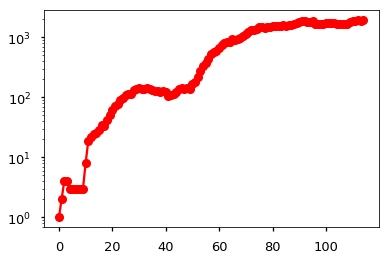

In [227]:
plt.plot(data_time,infected_individuals, '-or')
plt.yscale("log")

In [199]:
@jit(nopython=True)
def seaird_model2(t, X, alpha, beta0,beta1,day0, gamma,sigma,p):
    
    if t <= day0:
        beta = beta0 
    else: 
        beta=beta1# days0 day of implementation of the measure
    S, E, A, I, R,D = X
    N=S+E+A+I+R
    dS = - beta * S * (I+A)/N
    dE = beta * S * (I+A)/N  - sigma * E
    dA = (1-alpha)*sigma*E-gamma*A
    dI = (alpha)*sigma * E - gamma * I
    dR = gamma *(1-p)* I
    dD = gamma * p * I

    return dS, dE,dA, dI,dR, dD

In [200]:
def seaird_ode_solver2(y0, t_span, t_eval,alpha, beta0,beta1,day0, gamma,sigma,p):
    solution_ODE = solve_ivp(
        fun=lambda t, y: seaird_model2(t, y, alpha=alpha, beta0=beta0,beta1=beta1, day0=day0,gamma=gamma,sigma=sigma, p=p), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    
    return solution_ODE

In [201]:
@theano.compile.ops.as_op(itypes=[t.dvector,t.dvector,t.dvector,t.dscalar, t.dscalar, t.dscalar,t.dscalar,t.lscalar], otypes=[t.dvector])
def seaird_ode_solver_wrapper_inf(time_exp, f_observations, initial_conditions, alpha, beta0,beta1,gamma,day0 ):
    time_span = (time_exp.min(), time_exp.max())
    p=0.023
    sigma=1.0/14.0
    
    y_model = seaird_ode_solver2(initial_conditions, time_span, time_exp,alpha, beta0,beta1,day0, gamma,sigma,p)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, _,simulated_i,simulated_r, simulated_d = simulated_ode_solution # comaprtiment che voglio usare. _ indica compartimento da non salvare

    simulated_if=np.reshape(simulated_i,len(simulated_i))

    simulated_rf=np.reshape(simulated_r,len(simulated_r))
    simulated_df=np.reshape(simulated_d,len(simulated_d))
    return np.concatenate((simulated_if,simulated_rf,simulated_df))

In [221]:
def log_likelihood(p_1, p_2,  f1, f2, ):
    #p_1: parameter for bernoulli variable (1st variable)
    #mu_2, sigma_2: parameters for normal variable (2nd varaiable)
    #f1: an observation of feat1
    #f2: an observation of feat2
    #w1, w2: weight for building likelihood

    LL1 = pm.Poisson('LL1', mu=p_1, observed=f1)
    LL2 = pm.Poisson('LL2', mu=p_2, observed=f2)

    logP = sum(LL1 + LL2)

    return(logP)

with pm.Model() as model_mcmc2:
    # Prior distributions for the model's parameters
    beta0 = pm.Uniform('beta0', lower=1.0, upper=1.5)
    beta1 = pm.Uniform('beta1', lower=0.01, upper=0.4)
    #beta2 = pm.Uniform('beta2', lower=1.0, upper=1.5)
    #Tinc = pm.TruncatedNormal('Tinc', mu=5, sd=2,lower=1,upper=14)
    gamma=pm.TruncatedNormal("gamma",mu=1.0/5.0, sd=1.0/2.0,lower=1.0/14,upper=1.0/1)
    alpha = pm.Uniform('alpha', lower=0.3, upper=0.5)
    day0=pm.DiscreteUniform('day0',lower=30,upper=70)
    #day1=pm.DiscreteUniform('day1',lower=60,upper=90)
    #Tinf = pm.TruncatedNormal('Tinf', mu=9, sd=2,lower=4,upper=12)
    #sigma0=pm.TruncatedNormal("sigma0",mu=1.0/14.0, sd=0.05,lower=0.001,upper=0.15)
    #sigma=pm.Deterministic("sigma",sigma0)
    # Defining the deterministic formulation of the problem
    sol = pm.Deterministic('seaird_model2', seaird_ode_solver_wrapper_inf(
        theano.shared(data_time), 
        theano.shared(infected_individuals), 
        theano.shared(np.array(y0_seaird).astype(np.float64)),
        alpha,
        beta0,
        beta1,
        gamma,
        day0
        )
    )

    res=np.concatenate((infected_individuals,recovered_individuals,dead_individuals))
    
    likelihood_model = pm.Poisson('likelihood_model', mu=sol, observed=res)
    step2 = pm.Metropolis()
    seaird2_trace = pm.sample(draws=1000, chains = 2, step=step2,tune = 500, njobs=-1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [day0]
>Metropolis: [alpha]
>Metropolis: [gamma]
>Metropolis: [beta1]
>Metropolis: [beta0]
100%|██████████| 1500/1500 [02:01<00:00, 12.36it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c352ff610>,
      dtype=object)

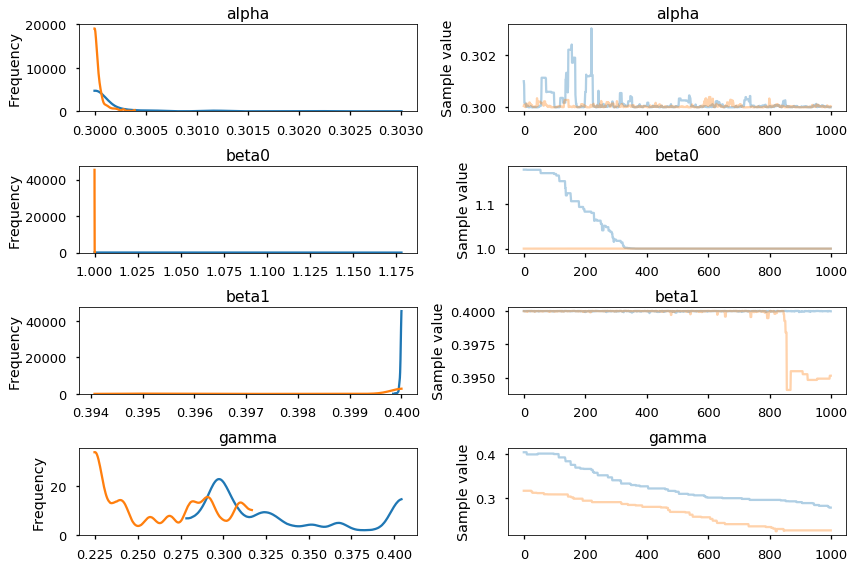

In [222]:
pm.traceplot(seaird2_trace,[alpha,beta0,beta1,gamma])

In [223]:
ppc2 = pm.sample_posterior_predictive(seaird2_trace, model=model_mcmc2, samples=4000)

100%|██████████| 4000/4000 [00:01<00:00, 2088.73it/s]


In [224]:
pm.summary(seaird2_trace,[alpha,beta0,beta1,day0,gamma]).round(3)

mean     sd  mc_error  hpd_2.5  hpd_97.5   n_eff   Rhat
alpha   0.300  0.000     0.000    0.300     0.301  31.110  1.052
beta0   1.018  0.047     0.005    1.000     1.168   5.300  1.161
beta1   0.400  0.001     0.000    0.395     0.400   8.856  1.084
day0   57.395  9.724     0.972   40.000    70.000   2.218  1.686
gamma   0.297  0.046     0.005    0.227     0.399   2.379  1.602

In [225]:
v=ppc2['likelihood_model']
infec_v=v[:,:len(data_time)]
recovered_v=v[:,len(data_time):2*len(data_time)]
dead_v=v[:,2*len(data_time):]

Text(0.5,1,'Posterior predictive on the Senegal set')

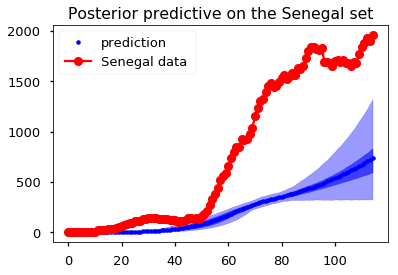

In [226]:
plt.plot(data_time, np.asarray(infec_v).mean(axis=0), '.b')
plt.fill_between(data_time, np.quantile(np.asarray(infec_v),0.25, axis=0),np.quantile(np.asarray(infec_v),0.75, axis=0), alpha=0.6,color='b')
plt.fill_between(data_time,np.quantile(np.asarray(infec_v),0.025, axis=0),np.quantile(np.asarray(infec_v),0.975, axis=0), alpha=0.4,color='b')
plt.plot(data_time,res[:len(data_time)], '-or')
proxy_arts = [plt.Line2D([0], [0], marker='.', linestyle='', color='b'),
                plt.Line2D([0], [0], marker='o', linestyle='-', color='r')]
plt.legend(handles=proxy_arts, labels=['prediction', 'Senegal data '])
plt.title('Posterior predictive on the Senegal set')

Text(0.5,1,'Posterior predictive Senegalese Recovered')

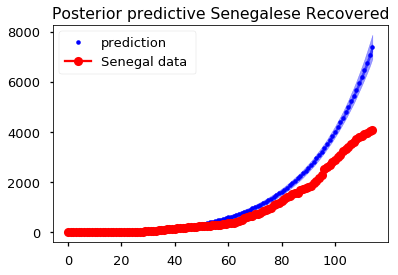

In [219]:
plt.plot(data_time, np.asarray(recovered_v).mean(axis=0), '.b')
plt.fill_between(data_time, np.quantile(np.asarray(recovered_v),0.25, axis=0),np.quantile(np.asarray(recovered_v),0.75, axis=0), alpha=0.6,color='b')
plt.fill_between(data_time,np.quantile(np.asarray(recovered_v),0.025, axis=0),np.quantile(np.asarray(recovered_v),0.975, axis=0), alpha=0.4,color='b')
plt.plot(data_time,res[len(data_time):2*len(data_time)], '-or')
proxy_arts = [plt.Line2D([0], [0], marker='.', linestyle='', color='b'),
                plt.Line2D([0], [0], marker='o', linestyle='-', color='r')]
plt.legend(handles=proxy_arts, labels=['prediction', 'Senegal data '])
plt.title('Posterior predictive Senegalese Recovered')

Text(0.5,1,'Posterior predictive Senegalese Dead')

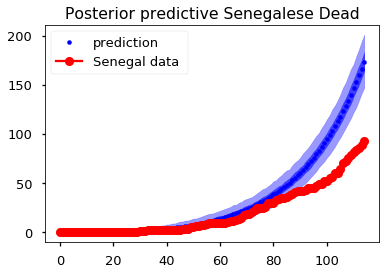

In [220]:
plt.plot(data_time, np.asarray(dead_v).mean(axis=0), '.b')
plt.fill_between(data_time, np.quantile(np.asarray(dead_v),0.25, axis=0),np.quantile(np.asarray(dead_v),0.75, axis=0), alpha=0.6,color='b')
plt.fill_between(data_time,np.quantile(np.asarray(dead_v),0.025, axis=0),np.quantile(np.asarray(dead_v),0.975, axis=0), alpha=0.4,color='b')
plt.plot(data_time,res[2*len(data_time):], '-or')
proxy_arts = [plt.Line2D([0], [0], marker='.', linestyle='', color='b'),
                plt.Line2D([0], [0], marker='o', linestyle='-', color='r')]
plt.legend(handles=proxy_arts, labels=['prediction', 'Senegal data '])
plt.title('Posterior predictive Senegalese Dead')